In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Found cached dataset subjqa (C:/Users/BarkY/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 127.18it/s]


In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [5]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

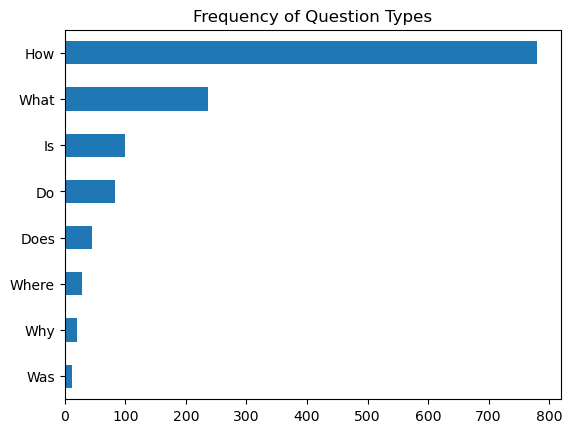

In [7]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [8]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
            .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Tokenizing text for QA

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading: 100%|█████████████████████████████████████████████████████████████████████| 477/477 [00:00<00:00, 477kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 226k/226k [00:00<00:00, 1.08MB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 74.6kB/s]


In [10]:
question = "How much music can this hold?"

context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [11]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [12]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading: 100%|██████████████████████████████████████████████████████████████████| 127M/127M [00:19<00:00, 6.68MB/s]


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [13]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


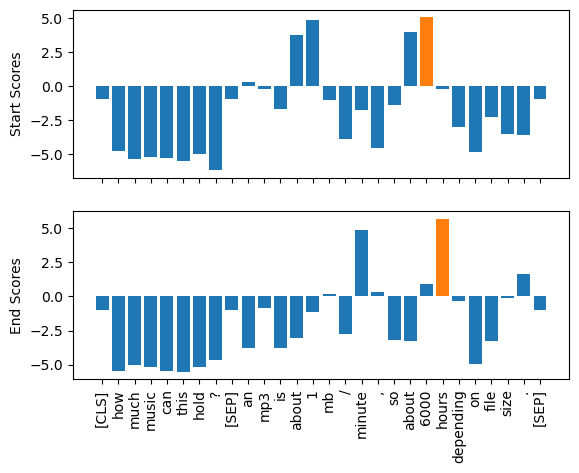

In [14]:
import numpy as np

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [15]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [16]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

C:\Users\BarkY\anaconda3\envs\pytorch-env\lib\site-packages\transformers\pipelines\question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651625871658325, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082915902137756,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253461450338364,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [17]:
# question with no anwser possible, assign high start and end score to the [CLS] token
pipe(question="Why is there no data?", context=context,
handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

In [18]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], truncation=True, return_overflowing_tokens=True, max_length=100, stride=25)

for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [19]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Using Haystack to Build a QA Pipeline

Linux
import os
from subprocess import Popen, PIPE, STDOUT
Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT)
Wait until Elasticsearch has started
!sleep 30

In [20]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "DESKTOP-4PKJAL7",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "EinT3Mr3RLubjO2rJ3sVYw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "zip",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   540  100   540    0     0   154k      0 --:--:-- --:--:-- --:--:--  175k


In [24]:
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO - haystack.telemetry -  Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


In [25]:
dfs["train"].iloc[0]

domain                                                                                           electronics
nn_mod                                                                                                 great
nn_asp                                                                                         bass response
query_mod                                                                                          excellent
query_asp                                                                                               bass
q_reviews_id                                                                0514ee34b672623dff659334a25b599b
question_subj_level                                                                                        5
ques_subj_score                                                                                          0.5
is_ques_subjective                                                                                     False
review_id          

In [29]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta": {"item_id": row["title"], "question_id": row["id"], "split": split}}
           for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


## Initializing a retriever

In [30]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

WARNING - haystack.retriever.sparse -  This class is now deprecated. Please use the BM25Retriever instead


In [31]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [32]:
print(retrieved_docs[0])

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never  ...'>
